In [2]:
# ==================== [LIBRARIES] ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, 
                           confusion_matrix, 
                           accuracy_score,
                           roc_curve, 
                           auc)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



In [3]:
# ==================== [DATA PREPARATION] ====================
# [1] Load dataset
file_path = "ulasan_goride_bersihhh.csv"  # <<< CHANGE THIS PATH
df = pd.read_csv(file_path)

# [2] Normalize column names
df.columns = df.columns.str.lower().str.strip()

# [3] Handle missing values - more thoroughly check for NaN values
print(f"Dataset shape before cleaning: {df.shape}")
print(f"Missing values before cleaning:\n{df.isna().sum()}")

# Drop rows with NaN values in text or label columns
df = df.dropna(subset=['ulasan_bersih', 'label'])

# Additional check to ensure no NaN values in label column
df = df[df['label'].notna()]

# [4] Convert label column to numeric if needed
# Check if labels are already numeric (0 and 1)
if df['label'].dtype == 'object':
    # If they're strings ('negatif'/'positif'), convert them
    label_mapping = {'negatif': 0, 'positif': 1}
    df['label'] = df['label'].map(label_mapping)
else:
    # If they're already numeric, ensure they're 0 and 1
    df['label'] = df['label'].astype(int)
    
# Final verification step
print(f"Dataset shape after cleaning: {df.shape}")
print(f"Missing values after cleaning:\n{df.isna().sum()}")
print(f"Label distribution:\n{df['label'].value_counts()}")



Dataset shape before cleaning: (1036, 13)
Missing values before cleaning:
user_name           0
rating              0
ulasan              0
date                0
label               0
sentiment           0
after_clean         4
after_slang         4
after_repeated      4
after_tokenize      0
after_stopwords     0
after_stem          0
ulasan_bersih      10
dtype: int64
Dataset shape after cleaning: (1026, 13)
Missing values after cleaning:
user_name          0
rating             0
ulasan             0
date               0
label              0
sentiment          0
after_clean        0
after_slang        0
after_repeated     0
after_tokenize     0
after_stopwords    0
after_stem         0
ulasan_bersih      0
dtype: int64
Label distribution:
label
1    542
0    484
Name: count, dtype: int64


In [4]:
# ==================== [FEATURE ENGINEERING] ====================
# [1] Prepare features and target
X = df['ulasan_bersih']  # <<< TEXT COLUMN
y = df['label']          # <<< LABEL COLUMN

# Verify no NaN values remain in features or target
assert X.isna().sum() == 0, "Still have NaN values in X features"
assert y.isna().sum() == 0, "Still have NaN values in y target"

# [2] Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Anda bisa mencetak bentuk (shape) dari masing-masing set untuk memverifikasi
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (820,)
Shape of X_test: (206,)
Shape of y_train: (820,)
Shape of y_test: (206,)


In [5]:
# ==================== [MODEL PIPELINE] ====================
# [1] Define pipeline
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),      # <<< ADJUST N-GRAM RANGE
        max_features=3000,       # <<< ADJUST MAX FEATURES
        sublinear_tf=True
    )),
    # ('smote', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])

# [2] Hyperparameter tuning grid
param_grid = {
    'svm__C': [0.1, 1, 10],            # <<< ADJUST HYPERPARAMETERS
    'svm__kernel': ['linear', 'rbf'],   # <<< ADJUST KERNELS
    'svm__gamma': ['scale', 'auto']     # <<< ADJUST GAMMA OPTIONS
}

# [3] Grid search setup
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1',                       # <<< CHANGE SCORING METRIC
    cv=5,                              # <<< ADJUST CV FOLDS
    verbose=1,
    n_jobs=-1
)



In [6]:
# ==================== [MODEL TRAINING] ====================
print("🚀 Training model...")
grid_search.fit(X_train, y_train)



🚀 Training model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=3000,
                                                        ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf']},
             scoring='f1', verbose=1)


✅ Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        97
           1       0.95      0.85      0.90       109

    accuracy                           0.90       206
   macro avg       0.90      0.90      0.90       206
weighted avg       0.90      0.90      0.90       206



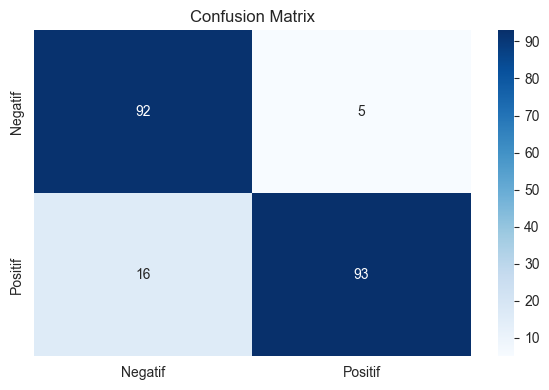

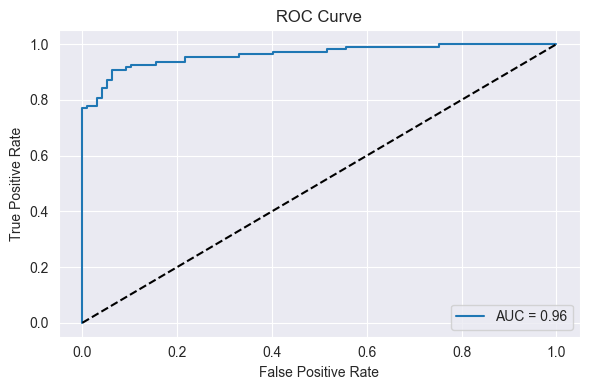

In [25]:
# ==================== [EVALUATION] ====================
# [1] Get predictions
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]

# [2] Print metrics
print("\n✅ Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# [3] Confusion matrix plot
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
# Adjust labels for confusion matrix
label_names = {0: 'Negatif', 1: 'Positif'}
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[label_names[0], label_names[1]],
            yticklabels=[label_names[0], label_names[1]])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# [4] ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# # ===== Bagian H: Save Model =====
# import joblib
# print("\n=== Saving Model ===")
# joblib.dump(model, 'svm_model1_tanpa_smote.pkl')
# joblib.dump(tfidf, 'tfidf_vectorizer2_tanpa_smote.pkl')
# print("Model saved successfully!")



In [8]:
# ==================== [PREDICTION FUNCTION] ====================
def predict_sentiment(model, texts):
    """Predict sentiment for new texts"""
    predictions = []
    probabilities = []
    
    # [1] For printing actual predictions
    for text in texts:
        # Ensure text is not NaN
        if pd.isna(text):
            print(f"\n⚠️ Warning: Skipping NaN text")
            continue
            
        # Convert to list if single text
        text_list = [text]
        
        # Get predictions
        pred = model.predict(text_list)[0]
        prob = model.predict_proba(text_list)[0][1]
        
        # Store results
        predictions.append(pred)
        probabilities.append(prob)
        
        # Print formatted result
        sentiment = 'Positif' if pred == 1 else 'Negatif'
        print(f"\n📝 Review: {text}")
        print(f"🔮 Prediction: {sentiment}")
        print(f"📊 Confidence: {prob:.2%}")
    
    return np.array(predictions), np.array(probabilities)



In [50]:
# ==================== [DEMO PREDICTIONS] ====================
test_reviews = [
    "bagus bangettt pliss ih aku slalu dapet diskon goride jadi seribu🤩🤩🤩",
    "tiap pesen go ride selalu lama dapetnya, mau ujan ato engga, selalu lama, nunggu sampe setengah jam lebih juga ngga dapet dapet, ngga rekomen buat yang lagi dikejar waktu, perbaiki tuh yang suka matiin aplikasi",
    "makasih sudah menghadirkan goride hemat, kalau bisa banyakin promo yaww"
]

print("\n🔮 Testing with sample reviews:")
predict_sentiment(grid_search, test_reviews)


🔮 Testing with sample reviews:

📝 Review: bagus bangettt pliss ih aku slalu dapet diskon goride jadi seribu🤩🤩🤩
🔮 Prediction: Positif
📊 Confidence: 95.78%

📝 Review: tiap pesen go ride selalu lama dapetnya, mau ujan ato engga, selalu lama, nunggu sampe setengah jam lebih juga ngga dapet dapet, ngga rekomen buat yang lagi dikejar waktu, perbaiki tuh yang suka matiin aplikasi
🔮 Prediction: Negatif
📊 Confidence: 19.93%

📝 Review: makasih sudah menghadirkan goride hemat, kalau bisa banyakin promo yaww
🔮 Prediction: Positif
📊 Confidence: 64.23%


(array([1, 0, 1]), array([0.95784689, 0.19925859, 0.64227712]))

In [46]:
import joblib
# Save the model and vectorizer
print("\n=== Saving Model ===")
joblib.dump(grid_search, 'svm_model_tanpa_smote.pkl')
joblib.dump(grid_search.best_estimator_.named_steps['tfidf'], 'tfidf_vectorizer_tanpa_smote.pkl')
print("Model saved successfully!")


=== Saving Model ===
Model saved successfully!
